In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pytz
import json
import re
import csv
import matplotlib.pyplot as plt

In [2]:
# read in the jsonl file
with open('../../tpm-negotiation-data/pilot-1/batch_20240206_2201_3waynegotiation.scienceData.jsonl', 'r') as json_file:
    negotiations_json_list = list(json_file)

In [3]:
def calculate_seconds_elapsed(time1, time2):
    # Convert string times to datetime objects
    time_format = "%Y-%m-%dT%H:%M:%S.%fZ"
    dt1 = datetime.strptime(time1, time_format)
    dt2 = datetime.strptime(time2, time_format)

    # Add UTC timezone information
    dt1 = dt1.replace(tzinfo=pytz.utc)
    dt2 = dt2.replace(tzinfo=pytz.utc)

    # Calculate the time difference
    time_difference = dt2 - dt1

    # Convert the time difference to seconds
    seconds_elapsed = time_difference.total_seconds()

    return seconds_elapsed

In [4]:
# save the deliberations we have so far
games = {}

file_path = '../raw_data/negotiation_pilot_data_02_07_24.csv'

with open(file_path, 'w', newline='') as csvfile:
    fieldnames = ["conversation_num", "message",  "timestamp", "organization", "speaker_id"]
    
    # Create a DictWriter with the CSV file and fieldnames
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    # Write the header
    writer.writeheader()

    for item in negotiations_json_list:
        convo_dict = json.loads(item)

        # Filter out my tests from 2/06; look only at real pilot results from 2/07
        try:
            if (datetime.strptime(convo_dict["timeComplete"], "%Y-%m-%dT%H:%M:%S.%fZ") < datetime(2024, 2, 7, 14, 0)):
                continue
        except:
            # no time data found
            continue

        # Process the negotiation data
        gameId = convo_dict['gameId']
        playerId = convo_dict['surveys']['survey_SVI_exit_undefined']['playerId']

        """
        Set up a dictionary that looks like the following:

        gameId: {
            "players" = {userId1: {
                deal_sheet: [responses]
                demographics: [responses]
                SVI: [responses]
                time_elapsed: [timeComplete-timeArrived]
                },
                userId2: {
                    deal_sheet: [responses]
                    demographics: [responses]
                    SVI: [responses]
                    time_elapsed: [timeComplete-timeArrived]
                },
                userId3: {
                    deal_sheet: [responses]
                    demographics: [responses]
                    SVI: [responses]
                    time_elapsed: [timeComplete-timeArrived]
                }}
            "last_message_time" = [time of last activity in the chat]
        }

        This parses everything about the games and the participants inside into a dictionary. 
        """
        if(gameId not in games.keys()):
            games[gameId] = {}
            # Write the chat to the CSV
            for chat in convo_dict['textChats']['Main Discussion']:
                writer.writerow({'conversation_num': convo_dict['gameId'], "message": chat['text'], "timestamp": chat['sender']['time'], "organization": chat['sender']['title'], "speaker_id": chat['sender']['id']})
            # time of last time stamp    
            games[gameId]["last_message_time"] = chat['sender']['time']
            # create empty players
            games[gameId]["players"] = {}

        if playerId not in games[gameId]["players"].keys():
            games[gameId]["players"][playerId] = {}

            # Deal Sheet
            try:
                games[gameId]["players"][playerId]["deal_sheet"] = {
                    "had_deal": convo_dict['prompts']['prompt_dealsheet1']["value"],
                    "deal_included":convo_dict['prompts']['prompt_dealsheet2']["value"],
                    "A_payoff": float(convo_dict['prompts']['prompt_dealsheet3']["value"]),
                    "B_payoff": float(convo_dict['prompts']['prompt_dealsheet4']["value"]),
                    "C_payoff": float(convo_dict['prompts']['prompt_dealsheet5']["value"])
                }
            except:
                print("Exception occurred in saving deal sheet for for player", playerId)

            # SVI
            try:
                games[gameId]["players"][playerId]["SVI"] = {
                    "responses": convo_dict['surveys']['survey_SVI_exit_undefined']['responses'],
                    "result": convo_dict['surveys']['survey_SVI_exit_undefined']['result']
                }
            except:
                print("Exception occurred in saving SVI for for player", playerId)

            # Demographics
            try:
                games[gameId]["players"][playerId]["demographics"] = convo_dict['surveys']['survey_Demographics_exit_1']['responses']
            except:
                print("Exception occurred in saving demographics for for player", playerId)

            # Time Spent
            games[gameId]["players"][playerId]["time_elapsed"] = calculate_seconds_elapsed(convo_dict["timeArrived"], convo_dict["timeComplete"])

       

Exception occurred in saving deal sheet for for player 01HP1XZQ7FXWF6XRCT0TFJXARF


This is our cleaned up negotiation data object

In [5]:
games

{'01HP1Y7T38P7KHDBVR7WBR0E2Y': {'last_message_time': 116.514,
  'players': {'01HP1Y0EH6DCFSKNN4MJYDQQ86': {'deal_sheet': {'had_deal': 'Yes',
     'deal_included': 'Yes',
     'A_payoff': 121.0,
     'B_payoff': 121.0,
     'C_payoff': 121.0},
    'SVI': {'responses': {'Instrumental Outcome 1': 7,
      'Instrumental Outcome 2': 7,
      'Instrumental Outcome 3': 1,
      'Instrumental Outcome 4': 7,
      'Self 1': 1,
      'Self 3': 7,
      'Self 4': 7,
      'Process 1': 7,
      'Process 2': 7,
      'Process 3': 7,
      'Process 4': 7,
      'Relationship 1': 7,
      'Relationship 2': 7,
      'Relationship 3': 7,
      'Relationship 4': 7,
      'Self 2': 7},
     'result': {'InstrumentalOutcome': '7.000',
      'Self': '7.000',
      'Process': '7.000',
      'Relationship': '7.000',
      'Global': '7.000',
      'Rapport': '7.000'}},
    'demographics': {'birth_year': '1983',
     'gender': 'male',
     'marital_status': 'Single Never Married',
     'language_primary': 'Engl

In [6]:
def plot_histogram(time_list, xlabel, title='Time Distribution Histogram', remove_extraneous_ticks = False):
    """
    Plots a histogram based on a list of time values.

    Parameters:
    - time_list (list): List of time values.

    Returns:
    None
    """
    # Plotting the histogram
    hist_values, bin_edges = np.histogram(time_list, bins=np.arange(min(time_list), max(time_list) + 2, 1))
    plt.bar(bin_edges[:-1], hist_values, width=1, color='blue', edgecolor='black', alpha=0.7)
    
    # Adding labels and title
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)

    # Set y-axis ticks to display only integers
    plt.yticks(np.arange(0, max(hist_values) + 2, 1))
    plt.xticks(np.arange(0, max(bin_edges), 1))
    plt.tick_params(axis='x', labelsize=8)

    if(remove_extraneous_ticks):
        plt.locator_params(axis='x', nbins=15)
    
    # Display the histogram
    plt.show()

# 1. Timing

In [7]:
# number of groups that completed
len(games.keys())

14

## How long did people negotiate for on average?

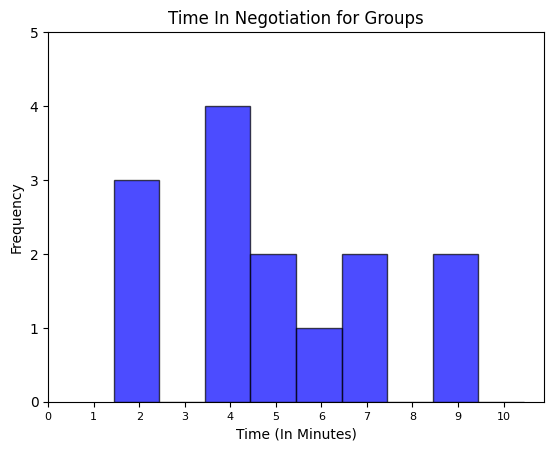

In [8]:
last_message_times = [games[gameId]["last_message_time"] for gameId in games.keys()]
last_message_times = np.divide(last_message_times, 60)
plot_histogram(last_message_times, xlabel = "Time (In Minutes)", title="Time In Negotiation for Groups")


In [9]:
np.mean(last_message_times)

5.554976190476189

## How long did people spend on the task / platform?

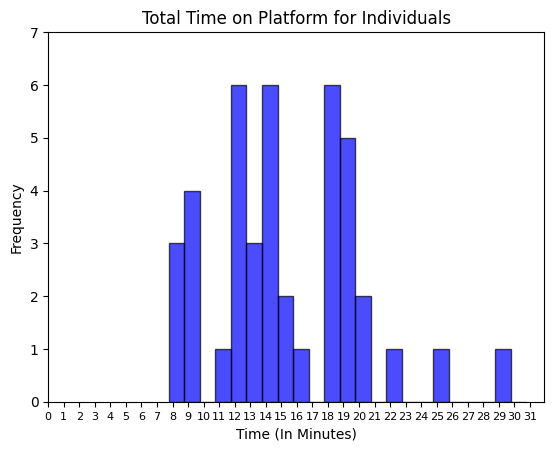

In [10]:
total_platform_times = []

for gameId in games.keys():
    total_platform_times = total_platform_times + [games[gameId]["players"][playerId]["time_elapsed"] for playerId in games[gameId]["players"]]

total_platform_times = np.divide(total_platform_times, 60)
plot_histogram(total_platform_times,  xlabel = "Time (In Minutes)", title="Total Time on Platform for Individuals")


In [11]:
np.mean(total_platform_times)

15.801259126984126

# 2. Outcomes

## How many teams got a valid deal / what were the distributions of deals?

In [12]:
def dicts_in_list_match(dict_list):
    if len(dict_list) < 2:
        return True  # If there's only one dictionary or an empty list, consider it as matching.

    keys_set = set(dict_list[0].keys())
    
    for d in dict_list[1:]:
        if set(d.keys()) != keys_set:
            return False  # If keys don't match across dictionaries, return False
        if any(d[key] != dict_list[0][key] for key in keys_set):
            return False  # If any values don't match, return False
    
    return True  # If all elements match, return True

In [13]:
def specific_values_match(dict_list, key1, key2):
    if len(dict_list) < 2:
        return True  # If there's only one dictionary or an empty list, consider it as matching.

    for d in dict_list[1:]:
        if d.get(key1) != dict_list[0].get(key1) or d.get(key2) != dict_list[0].get(key2):
            return False  # If values for specified keys don't match, return False

    return True  # If values for specified keys match across all dictionaries, return True


In [14]:
def count_nonzero_elements(list):
    count = 0
    for element in list:
        if element != 0:
            count += 1
    return count

In [15]:
all_deals = []
for gameId in games.keys():

    game_deal = {}
    deal_sheet_for_game = []
    try:
        for playerId in games[gameId]["players"]:
            deal_sheet_for_game.append(games[gameId]["players"][playerId]["deal_sheet"])

        # Logic for Checking the Valid Deal
        '''
        final deal format:
        game_deal = {
            valid_deal: True/False
            A_payoff: A_payoff
            B_payoff: B_payoff
            C_payoff: C_payoff
        }
        '''
        print("---------------")
        print(deal_sheet_for_game)
        # figure out if it was a 2 or 3 way deal

        # payoffs submitted by everyone
        A_payoffs = [deal['A_payoff'] for deal in deal_sheet_for_game]
        B_payoffs = [deal['B_payoff'] for deal in deal_sheet_for_game]
        C_payoffs = [deal['C_payoff'] for deal in deal_sheet_for_game]

        # allowable sum is determined by deal type
        allowable_sum = 0
        if(count_nonzero_elements(A_payoffs) > 1 and count_nonzero_elements(B_payoffs) > 1 and count_nonzero_elements(C_payoffs) > 1):
            allowable_sum = 121
        elif(count_nonzero_elements(A_payoffs) > 1 and count_nonzero_elements(B_payoffs) > 1):
            allowable_sum = 118
        elif(count_nonzero_elements(A_payoffs) > 1 and count_nonzero_elements(C_payoffs) > 1):
            allowable_sum = 84
        elif(count_nonzero_elements(B_payoffs) > 1 and count_nonzero_elements(C_payoffs) > 1):
            allowable_sum = 50

        # confirm deal sheets match for those involved in the deal!
        if(allowable_sum == 121):
            game_deal["valid_deal"] = dicts_in_list_match([deal for deal in deal_sheet_for_game])
        elif(allowable_sum == 118):
            game_deal["valid_deal"] = specific_values_match([deal for deal in deal_sheet_for_game], "A_payoff", "B_payoff")
        elif(allowable_sum == 84):
            game_deal["valid_deal"] = specific_values_match([deal for deal in deal_sheet_for_game], "A_payoff", "C_payoff")
        elif(allowable_sum == 50):
            game_deal["valid_deal"] = specific_values_match([deal for deal in deal_sheet_for_game], "B_payoff", "C_payoff")

        # confirm values add to appropriate number (the allowable sum)
        for deal in deal_sheet_for_game:
            total = round(deal['A_payoff']+deal['B_payoff']+deal['C_payoff'],0)
            if(total == allowable_sum or total == allowable_sum-1): # Do -1 give a little bit of room in rounding; some people added up to 120 instead
                game_deal["valid_deal"] = True
            else:
                print("Deal invalidated due to wrong sum.")
                print("GameID: ", gameId)
                print("Sum found:", total)
                print(deal)
                game_deal["valid_deal"] = False

        # Fill in the actual deal sheet
        if not game_deal["valid_deal"]:
            game_deal["gameId"] = gameId
            game_deal["A_payoff"] = 0
            game_deal["B_payoff"] = 0
            game_deal["C_payoff"] = 0
        else: # valid deal!
            # Check what type of deal it is
            if(allowable_sum == 121):
                game_deal["gameId"] = gameId
                game_deal["A_payoff"] = max([deal["A_payoff"] for deal in deal_sheet_for_game], key=[deal["A_payoff"] for deal in deal_sheet_for_game].count)
                game_deal["B_payoff"] = max([deal["B_payoff"] for deal in deal_sheet_for_game], key=[deal["B_payoff"] for deal in deal_sheet_for_game].count)
                game_deal["C_payoff"] = max([deal["C_payoff"] for deal in deal_sheet_for_game], key=[deal["C_payoff"] for deal in deal_sheet_for_game].count)
            elif(allowable_sum == 118): 
                game_deal["gameId"] = gameId
                game_deal["A_payoff"] = max([deal["A_payoff"] for deal in deal_sheet_for_game], key=[deal["A_payoff"] for deal in deal_sheet_for_game].count)
                game_deal["B_payoff"] = max([deal["B_payoff"] for deal in deal_sheet_for_game], key=[deal["B_payoff"] for deal in deal_sheet_for_game].count)
                game_deal["C_payoff"] = 0
            elif(allowable_sum == 84):
                game_deal["gameId"] = gameId
                game_deal["A_payoff"] = max([deal["A_payoff"] for deal in deal_sheet_for_game], key=[deal["A_payoff"] for deal in deal_sheet_for_game].count)
                game_deal["B_payoff"] = 0
                game_deal["C_payoff"] = max([deal["C_payoff"] for deal in deal_sheet_for_game], key=[deal["C_payoff"] for deal in deal_sheet_for_game].count)
            elif(allowable_sum == 50):
                game_deal["gameId"] = gameId
                game_deal["A_payoff"] = 0
                game_deal["B_payoff"] = max([deal["B_payoff"] for deal in deal_sheet_for_game], key=[deal["B_payoff"] for deal in deal_sheet_for_game].count)
                game_deal["C_payoff"] = max([deal["C_payoff"] for deal in deal_sheet_for_game], key=[deal["C_payoff"] for deal in deal_sheet_for_game].count)

    except KeyError:
        # no deal sheet submitted, so no deal
        print("Deal invalidated due to not submitting")
        print("GameID: ", gameId)
        game_deal["gameId"] = gameId
        game_deal["valid_deal"] = False
        game_deal["A_payoff"] = 0
        game_deal["B_payoff"] = 0
        game_deal["C_payoff"] = 0
    
    print("FINAL DEAL VALIDITY: ", game_deal["valid_deal"])
    print("---------------")
    all_deals.append(game_deal)


---------------
[{'had_deal': 'Yes', 'deal_included': 'Yes', 'A_payoff': 121.0, 'B_payoff': 121.0, 'C_payoff': 121.0}, {'had_deal': 'Yes', 'deal_included': 'Yes', 'A_payoff': 121.0, 'B_payoff': 121.0, 'C_payoff': 121.0}, {'had_deal': 'Yes', 'deal_included': 'Yes', 'A_payoff': 121.0, 'B_payoff': 121.0, 'C_payoff': 121.0}]
Deal invalidated due to wrong sum.
GameID:  01HP1Y7T38P7KHDBVR7WBR0E2Y
Sum found: 363.0
{'had_deal': 'Yes', 'deal_included': 'Yes', 'A_payoff': 121.0, 'B_payoff': 121.0, 'C_payoff': 121.0}
Deal invalidated due to wrong sum.
GameID:  01HP1Y7T38P7KHDBVR7WBR0E2Y
Sum found: 363.0
{'had_deal': 'Yes', 'deal_included': 'Yes', 'A_payoff': 121.0, 'B_payoff': 121.0, 'C_payoff': 121.0}
Deal invalidated due to wrong sum.
GameID:  01HP1Y7T38P7KHDBVR7WBR0E2Y
Sum found: 363.0
{'had_deal': 'Yes', 'deal_included': 'Yes', 'A_payoff': 121.0, 'B_payoff': 121.0, 'C_payoff': 121.0}
FINAL DEAL VALIDITY:  False
---------------
---------------
[{'had_deal': 'Yes', 'deal_included': 'Yes', 'A_pa

In [16]:
got_deals = [int(deal["valid_deal"]) for deal in all_deals]
A_payoffs = [deal["A_payoff"] for deal in all_deals]
B_payoffs = [deal["B_payoff"] for deal in all_deals]
C_payoffs = [deal["C_payoff"] for deal in all_deals]

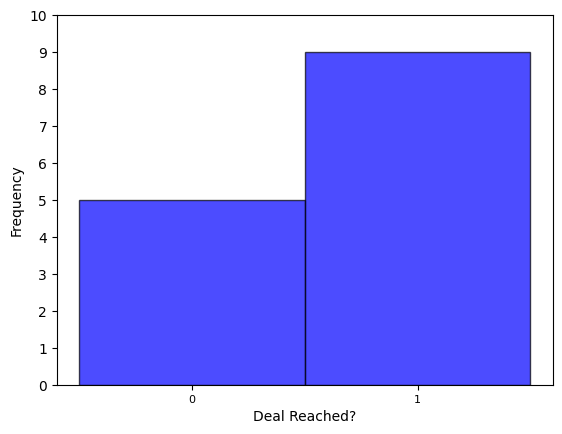

In [17]:
plot_histogram(got_deals, xlabel ="Deal Reached?", title="")

In [18]:
all_deals

[{'valid_deal': False,
  'gameId': '01HP1Y7T38P7KHDBVR7WBR0E2Y',
  'A_payoff': 0,
  'B_payoff': 0,
  'C_payoff': 0},
 {'valid_deal': True,
  'gameId': '01HP1YAGDJ5BYYPNWKPEG7MJCC',
  'A_payoff': 40.0,
  'B_payoff': 40.0,
  'C_payoff': 41.0},
 {'valid_deal': True,
  'gameId': '01HP1Y5Q4G5E4Q90871HF94NW5',
  'A_payoff': 40.0,
  'B_payoff': 40.0,
  'C_payoff': 40.0},
 {'valid_deal': True,
  'gameId': '01HP1YAX7DJJDZARVPFVAT9ZJV',
  'A_payoff': 40.0,
  'B_payoff': 40.0,
  'C_payoff': 41.0},
 {'valid_deal': True,
  'gameId': '01HP1Y7T39FNNFR8FEV6E6D7CR',
  'A_payoff': 49.0,
  'B_payoff': 49.0,
  'C_payoff': 23.0},
 {'valid_deal': False,
  'gameId': '01HP1Y97BPHCB17H84CCDR5RC9',
  'A_payoff': 0,
  'B_payoff': 0,
  'C_payoff': 0},
 {'gameId': '01HP1Y6D73DF53A88HX2J1BJK9',
  'valid_deal': False,
  'A_payoff': 0,
  'B_payoff': 0,
  'C_payoff': 0},
 {'valid_deal': True,
  'gameId': '01HP1YCYFXD540EJ343NXAKC45',
  'A_payoff': 40.333,
  'B_payoff': 40.333,
  'C_payoff': 40.333},
 {'valid_deal': Fa

In [19]:
pd.DataFrame(all_deals).sort_values("valid_deal", ascending=False)

,valid_deal,gameId,A_payoff,B_payoff,C_payoff
1,True,01HP1YAGDJ5BYYPNWKPEG7MJCC,40.000,40.000,41.000
2,True,01HP1Y5Q4G5E4Q90871HF94NW5,40.000,40.000,40.000
3,True,01HP1YAX7DJJDZARVPFVAT9ZJV,40.000,40.000,41.000
4,True,01HP1Y7T39FNNFR8FEV6E6D7CR,49.000,49.000,23.000
7,True,01HP1YCYFXD540EJ343NXAKC45,40.333,40.333,40.333
9,True,01HP1YNAPAXYKGZG1CDMASGGDX,40.000,40.000,40.000
10,True,01HP1YFRJD8BT0YNT6CN6V1RWW,40.000,40.000,40.000
12,True,01HP1YEWWY20737J2584P62VNH,40.000,40.000,41.000
13,True,01HP1Z29QMK52RZK8MBF9PXZMD,40.300,40.300,40.300
0,False,01HP1Y7T38P7KHDBVR7WBR0E2Y,0.000,0.000,0.000


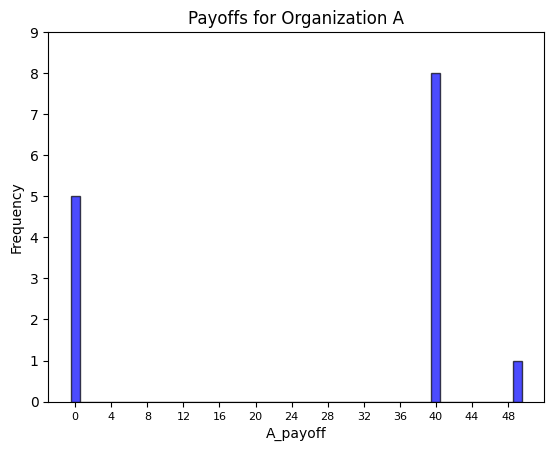

In [20]:
plot_histogram(A_payoffs,  xlabel = "A_payoff", title="Payoffs for Organization A", remove_extraneous_ticks = True)

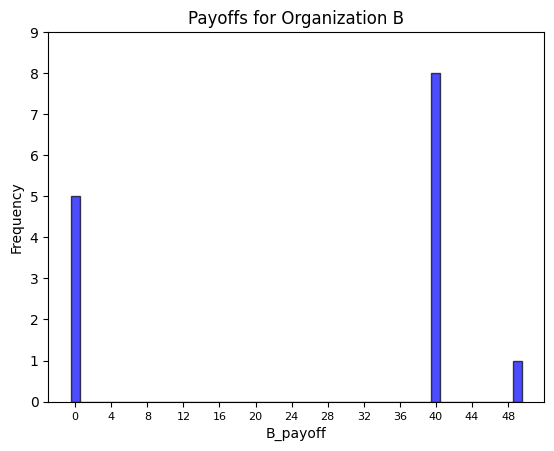

In [21]:
plot_histogram(B_payoffs,  xlabel = "B_payoff", title="Payoffs for Organization B", remove_extraneous_ticks = True)

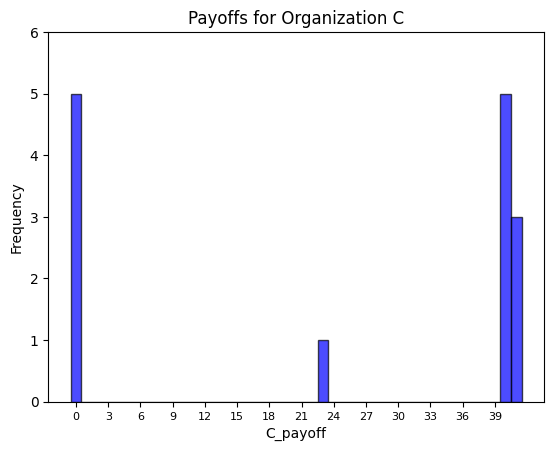

In [22]:
plot_histogram(C_payoffs,  xlabel = "C_payoff", title="Payoffs for Organization C", remove_extraneous_ticks = True)

## What was the distribution of Subjective Value?

In [23]:
subjective_values_all = []
for gameId in games.keys():
    try:
        for playerId in games[gameId]["players"]:
            subjective_values_all.append(games[gameId]["players"][playerId]["SVI"])
    except KeyError:
        pass

In [24]:
subjective_values_all

svi_self = [float(res['result']['Self']) for res in subjective_values_all]
svi_process = [float(res['result']['Process']) for res in subjective_values_all]
svi_relationship = [float(res['result']['Relationship']) for res in subjective_values_all]
svi_rapport = [float(res['result']['Rapport']) for res in subjective_values_all]
svi_global = [float(res['result']['Global']) for res in subjective_values_all]

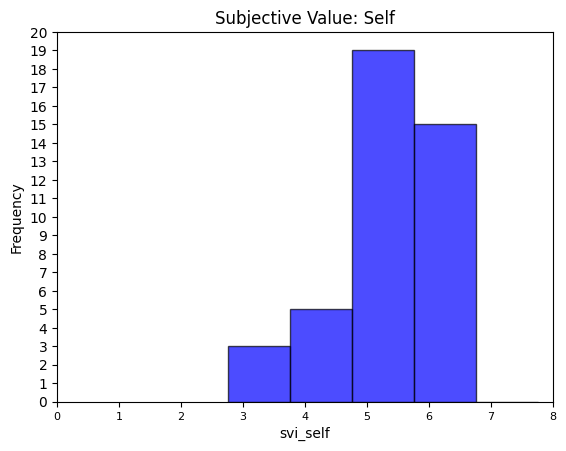

In [25]:
plot_histogram(svi_self,  xlabel = "svi_self", title="Subjective Value: Self")

In [26]:
np.mean(svi_self)

5.666666666666667

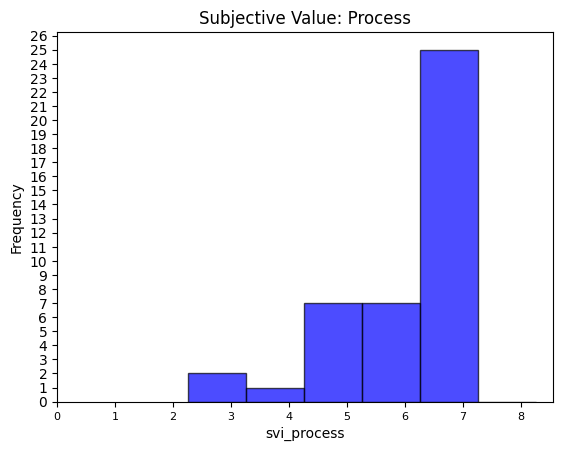

In [27]:
plot_histogram(svi_process,  xlabel = "svi_process", title="Subjective Value: Process")

In [28]:
np.mean(svi_process)

6.279761904761905

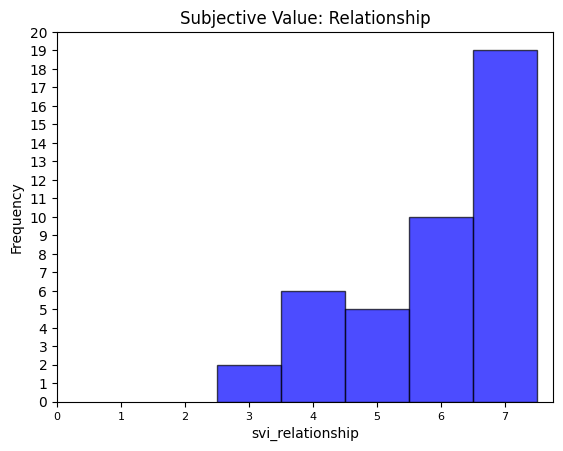

In [29]:
plot_histogram(svi_relationship,  xlabel = "svi_relationship", title="Subjective Value: Relationship")

In [30]:
np.mean(svi_relationship)

6.095238095238095

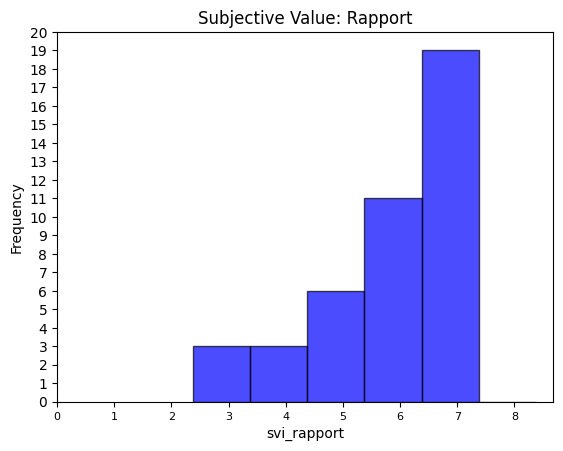

In [31]:
plot_histogram(svi_rapport,  xlabel = "svi_rapport", title="Subjective Value: Rapport")

In [32]:
np.mean(svi_rapport)

6.1875

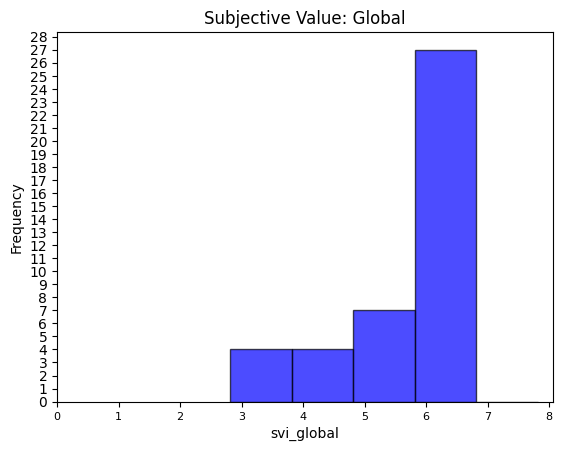

In [33]:
plot_histogram(svi_global,  xlabel = "svi_global", title="Subjective Value: Global")

In [34]:
np.mean(svi_global)

6.055976190476191

## Bonuses

In [35]:
# TODO